# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, ReLU, MaxPool2D, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import cv2

import os
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imghdr
from struct import unpack

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [27]:
data_dir = '../Dataset/' 

In [ ]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break   

bads = []
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            bads.append(image_path)  

print(len(bads))

# for name in bads:
#     os.remove(os.path.join(name))


In [ ]:
image_exts = ['jpeg','jpg', 'png']

for image_class in tqdm(os.listdir(data_dir)): 
    print(image_class)
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)

        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

  0%|          | 0/47 [00:00<?, ?it/s]

['Adho Mukha Svanasana',
 'Adho Mukha Vrksasana',
 'Alanasana',
 'Anjaneyasana',
 'Ardha Chandrasana',
 'Ardha Matsyendrasana',
 'Ardha Navasana',
 'Ardha Pincha Mayurasana',
 'Ashta Chandrasana',
 'Baddha Konasana',
 'Bakasana',
 'Balasana',
 'Bitilasana',
 'Camatkarasana',
 'Dhanurasana',
 'Eka Pada Rajakapotasana',
 'Garudasana',
 'Halasana',
 'Hanumanasana',
 'Malasana',
 'Marjaryasana',
 'Navasana',
 'Padmasana',
 'Parsva Virabhadrasana',
 'Parsvottanasana',
 'Paschimottanasana',
 'Phalakasana',
 'Pincha Mayurasana',
 'Salamba Bhujangasana',
 'Salamba Sarvangasana',
 'Setu Bandha Sarvangasana',
 'Sivasana',
 'Supta Kapotasana',
 'Trikonasana',
 'Upavistha Konasana',
 'Urdhva Dhanurasana',
 'Urdhva Mukha Svsnssana',
 'Ustrasana',
 'Utkatasana',
 'Uttanasana',
 'Utthita Hasta Padangusthasana',
 'Utthita Parsvakonasana',
 'Vasisthasana',
 'Virabhadrasana One',
 'Virabhadrasana Three',
 'Virabhadrasana Two',
 'Vrksasana']

# 3. Load Data

In [11]:
data = image_dataset_from_directory('../Dataset', batch_size = 32, label_mode='categorical', image_size=(227,227))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


Found 2756 files belonging to 47 classes.


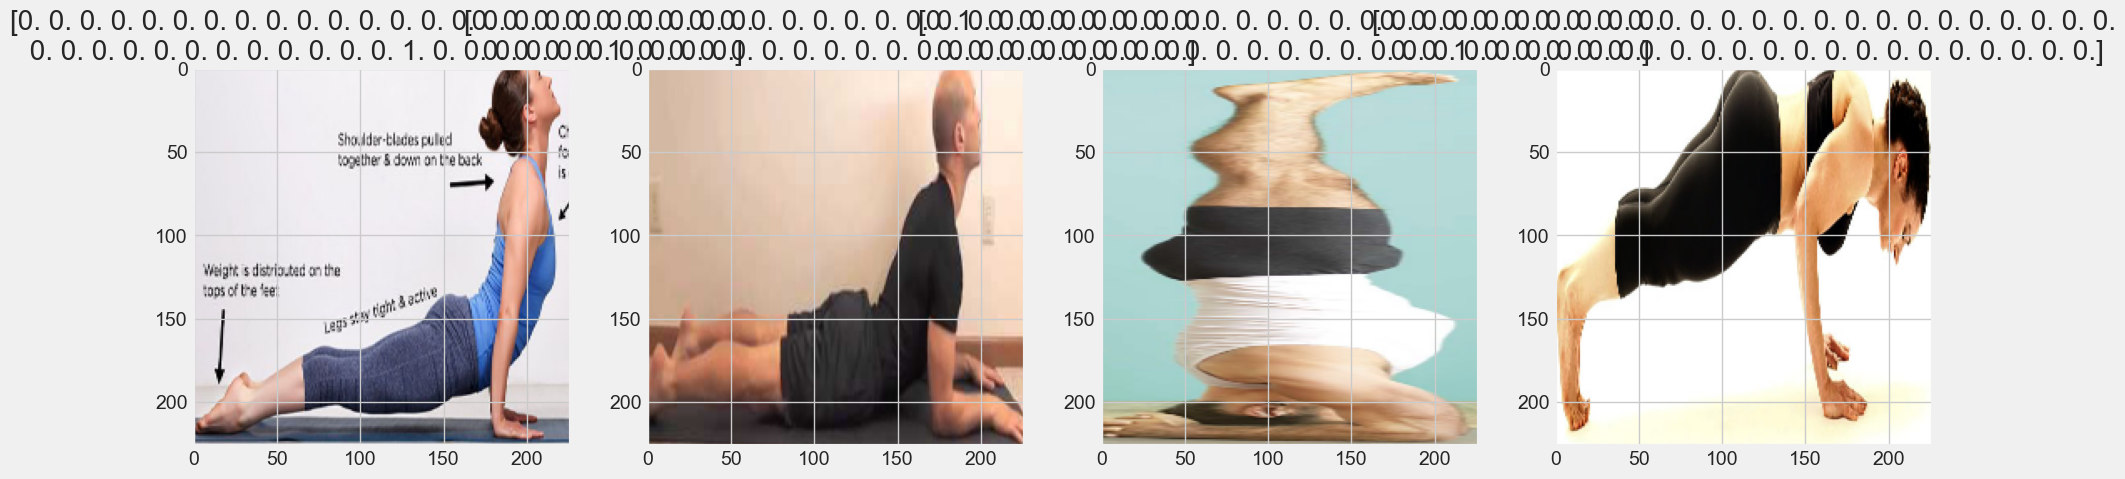

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

# 5. Split Data

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

60
17
8


# 6. Build Deep Learning Model

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(112,112,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.000_1)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [15]:
### Alexnet Algoritms

model = keras.Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation="relu", input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides= (2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(47, activation="softmax"))

model.compile(loss='categorical_crossentropy', 
            optimizer=Adam(lr=0.000_1), 
            metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(224,224,3)))
model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.9))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())


model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.75))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.001)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# model = Sequential()

# model.add(Conv2D(128, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same',  input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# # model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# # model.add(MaxPooling2D())
# # model.add(Dropout(0.4))
# # model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.2))

# model.add(Dense(4, activation='softmax'))

# opt = Adam(learning_rate = 0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(112,112,3)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.8))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.0001)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# 7. Train

In [16]:
epoch = 10

hist = model.fit(train, epochs=epoch, validation_data=val)

Epoch 1/10
60/60 [==============================] - 12s 128ms/step - loss: 6.0225 - accuracy: 0.1078 - val_loss: 3.9823 - val_accuracy: 0.0110
Epoch 2/10
60/60 [==============================] - 7s 121ms/step - loss: 2.8730 - accuracy: 0.3281 - val_loss: 4.3003 - val_accuracy: 0.0294
Epoch 3/10
60/60 [==============================] - 7s 121ms/step - loss: 1.8978 - accuracy: 0.4964 - val_loss: 4.5294 - val_accuracy: 0.0368
Epoch 4/10
60/60 [==============================] - 7s 122ms/step - loss: 1.4820 - accuracy: 0.5953 - val_loss: 4.6785 - val_accuracy: 0.0551
Epoch 5/10
60/60 [==============================] - 7s 123ms/step - loss: 1.0361 - accuracy: 0.7042 - val_loss: 3.9639 - val_accuracy: 0.1342
Epoch 6/10
60/60 [==============================] - 7s 122ms/step - loss: 0.7599 - accuracy: 0.7786 - val_loss: 3.8241 - val_accuracy: 0.1949
Epoch 7/10
60/60 [==============================] - 7s 122ms/step - loss: 0.5615 - accuracy: 0.8438 - val_loss: 2.6487 - val_accuracy: 0.3658
Epoch

# 8. Plot Performance

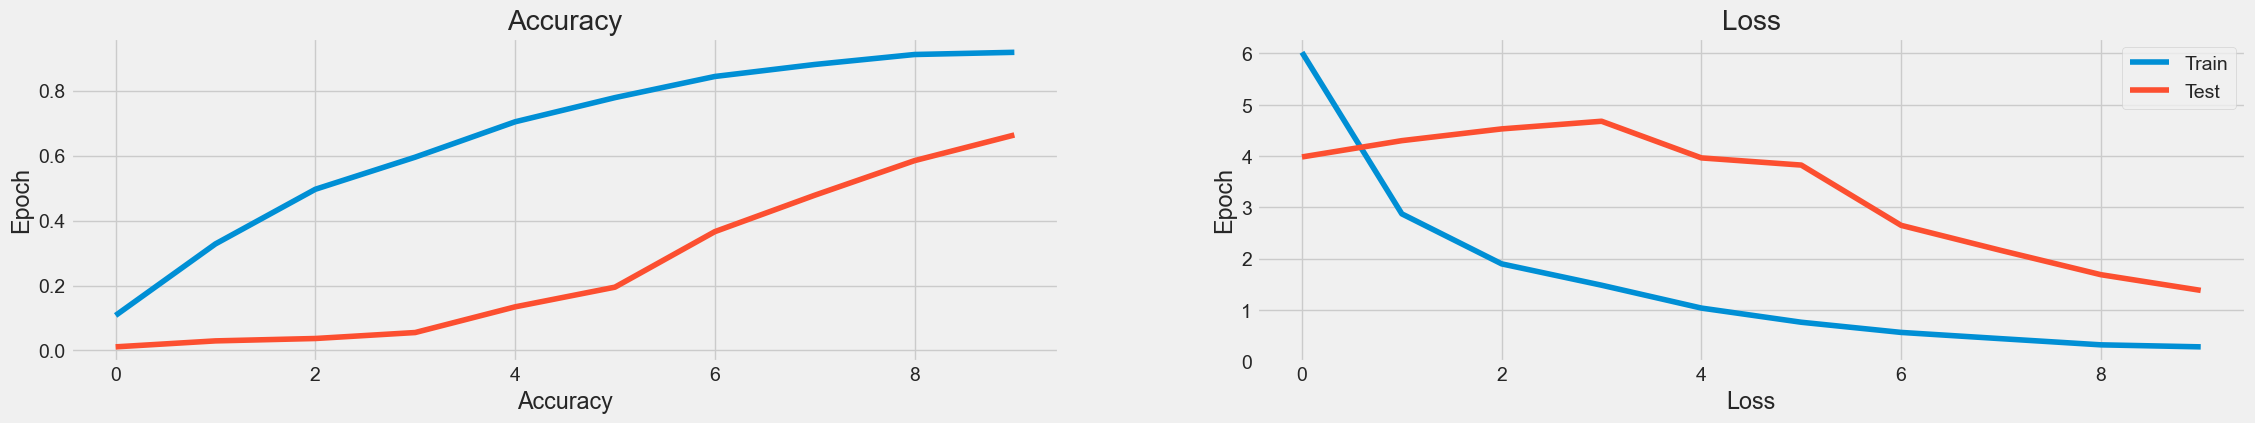

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 9. Evaluate

In [18]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision       : {pre.result().numpy()}")
print(f"Recall          : {re.result().numpy()}")
print(f"Binary Accuracy : {acc.result().numpy()}")


Precision       : 0.7175140976905823
Recall          : 0.49609375
Binary Accuracy : 0.9851229786872864


In [31]:
lab = []
for image_class in tqdm(os.listdir(data_dir)): 
    lab.append(image_class)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

C:\Users\indiz\AppData\Local\Temp\ipykernel_6460\585771962.py:17: RuntimeWarning: invalid value encountered in divide
  cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]


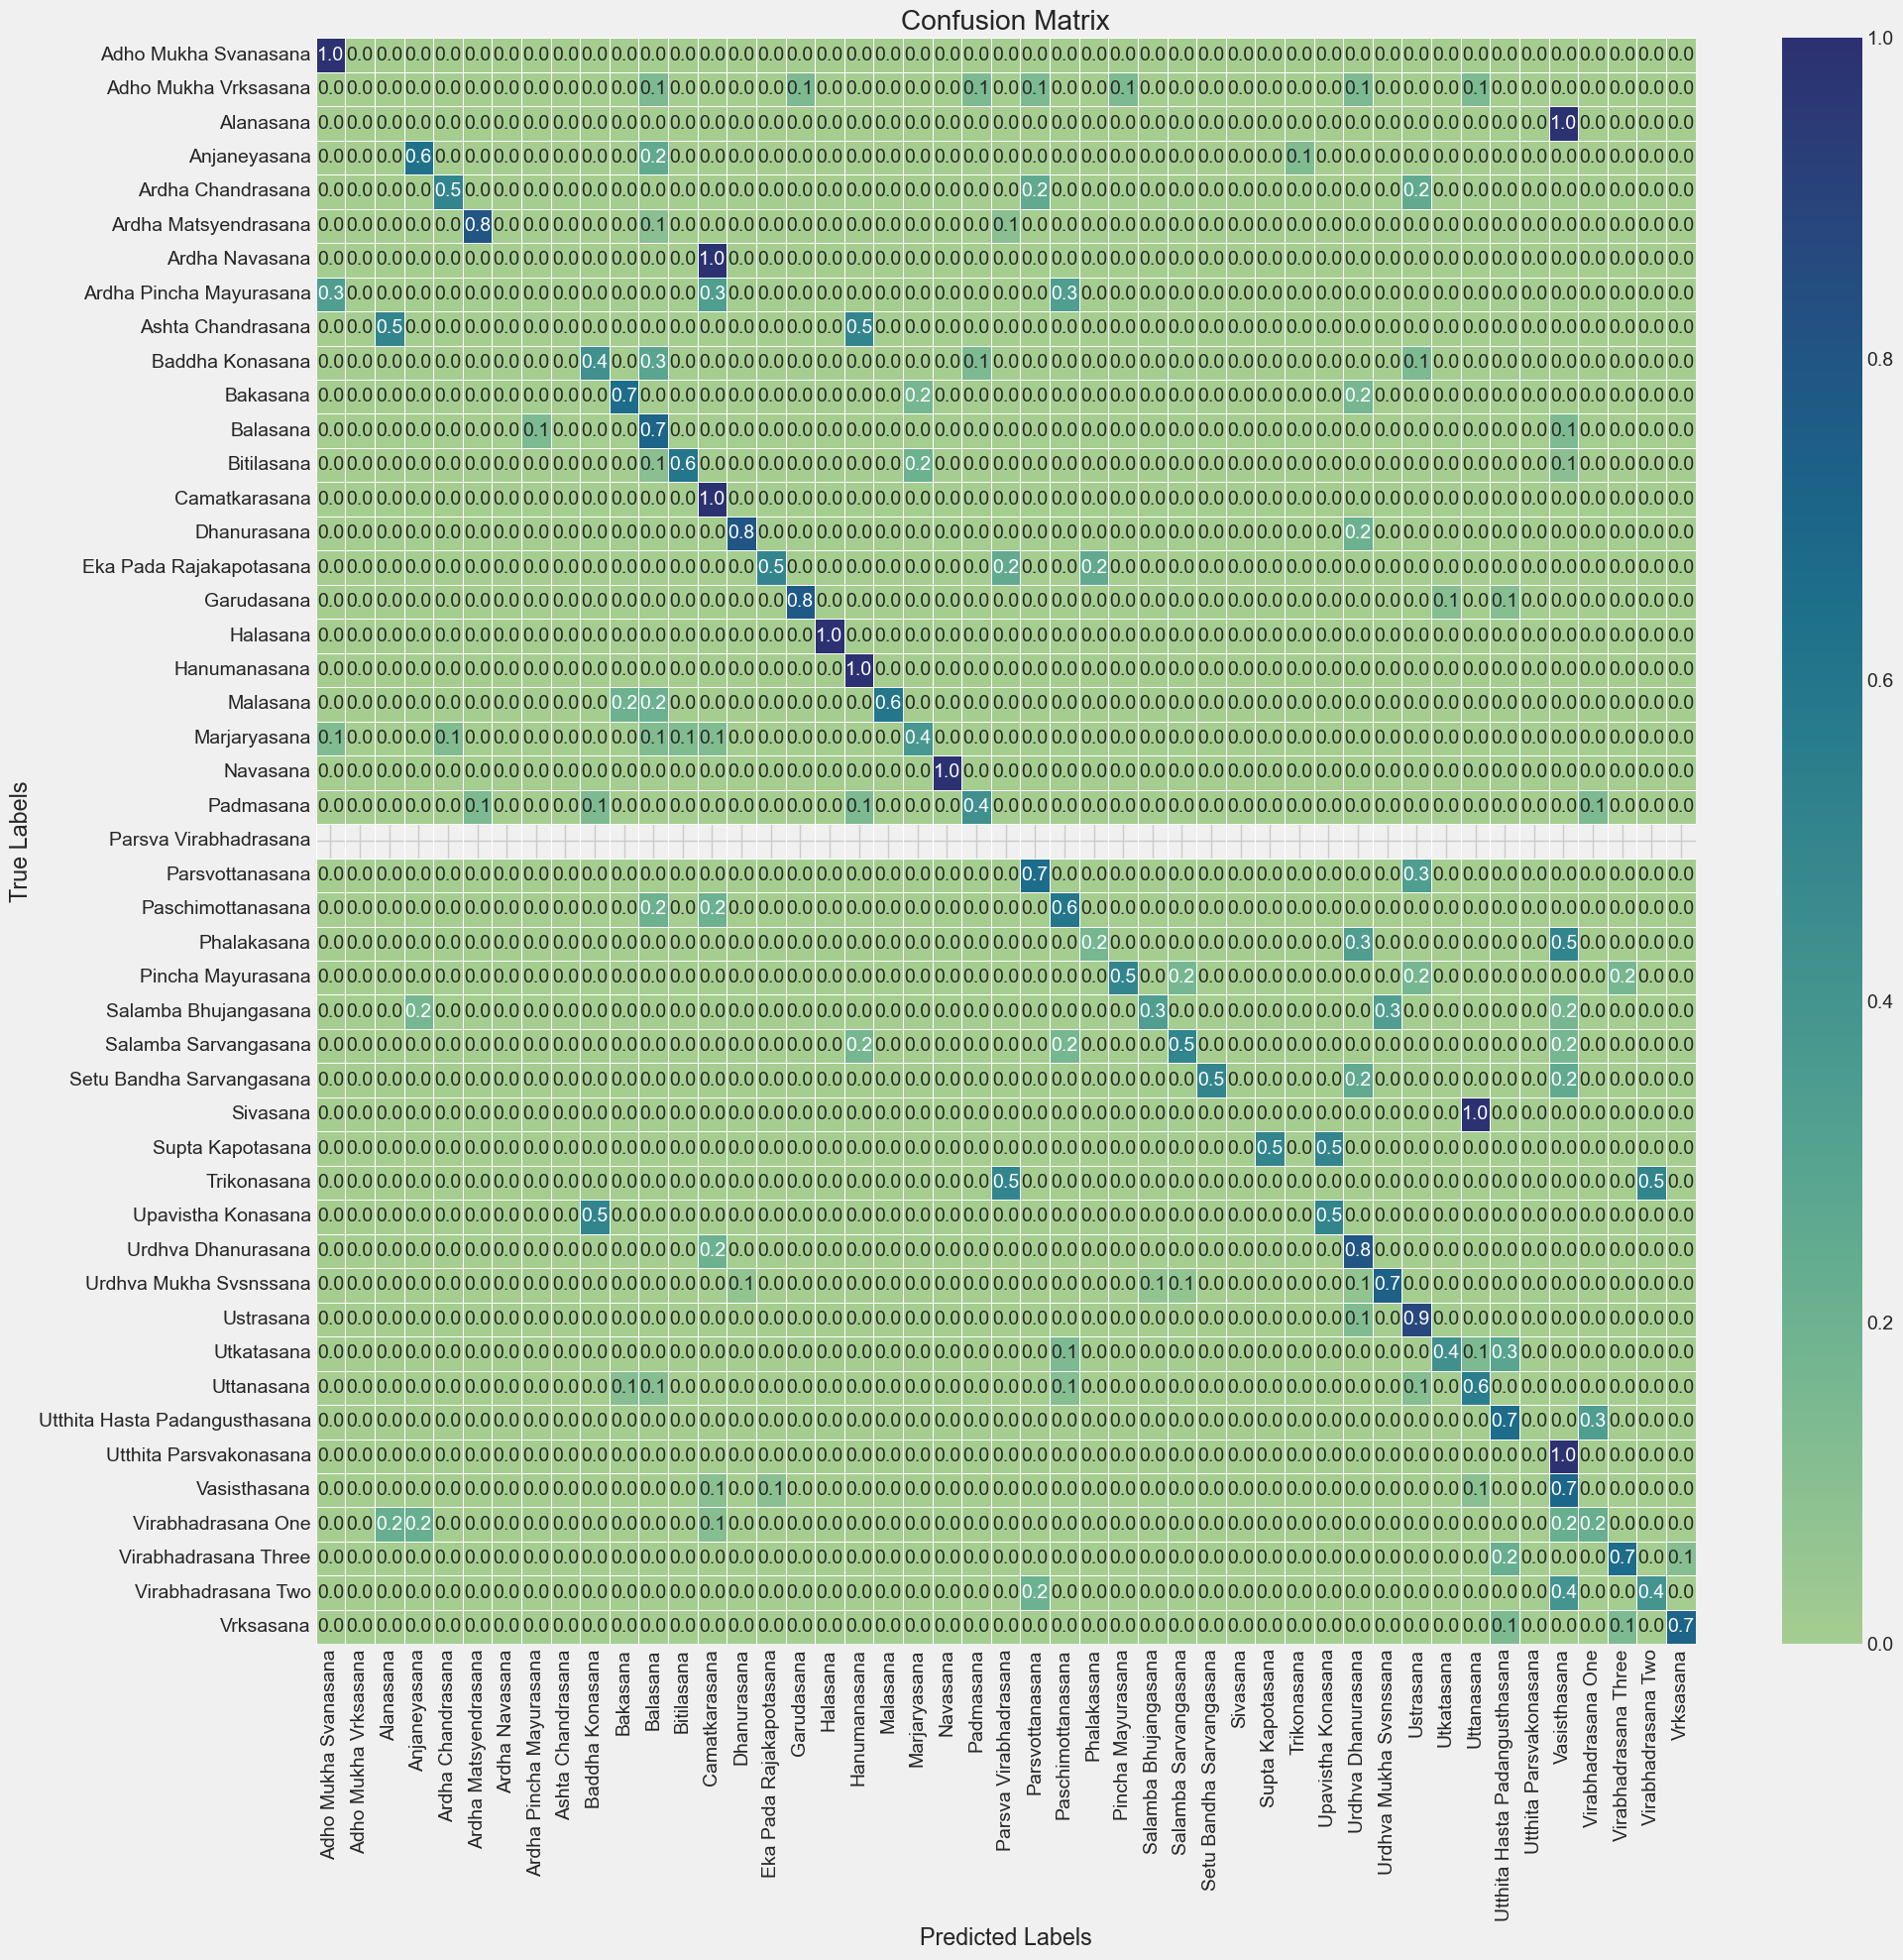

In [45]:
labels = []
for image_class in tqdm(os.listdir(data_dir)): 
    labels.append(image_class)

label_pred,label_true = [], []
for batch in test.as_numpy_iterator(): 
    X, Y = batch
    pred = model.predict(X, verbose=0)
    label_pred.append(pred.argmax(axis=1))
    label_true.append(Y.argmax(axis=1))

label_true = np.concatenate(label_true).tolist()
label_pred = np.concatenate(label_pred).tolist()

con_mat = confusion_matrix(label_true, label_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20,20)) 

# sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='crest', linewidth=.5, xticklabels=labels, yticklabels=labels, ax=ax)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 10. Test

In [ ]:
img_load = cv2.imread('TestImages/2021-08-18_12-42-27_UTC_2.jpg')
img = cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [69]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
pred = yhat.argmax()

if pred == 0 :
    print(f'Predicted class is Alifhia Fitri')
elif pred == 1:
    print(f'Predicted class is Delmira Prabu')
elif pred == 2:
    print(f'Predicted class is Haerakeuuu')
elif pred == 3:
    print(f'Predicted class is Jacquelyn Chandra')

1/1 [==============================] - 0s 22ms/step
[[6.5539710e-02 1.0556944e-03 9.3271786e-01 6.8666856e-04]]
Predicted class is Haerakeuuu


# 11. Save the Model

In [37]:
model.save(os.path.join('models','imageclassifier.h5'))

In [70]:
new_model = load_model('models/imageclassifier.h5')
pred_model = new_model.predict(np.expand_dims(resize/255, 0))
label = pred_model.argmax()

if label == 0 :
    print(f'Predicted class is Alifhia Fitri')
elif label == 1:
    print(f'Predicted class is Delmira Prabu')
elif label == 2:
    print(f'Predicted class is Haerakeuuu')
elif label == 3:
    print(f'Predicted class is Jacquelyn Chandra')

1/1 [==============================] - 0s 81ms/step
Predicted class is Haerakeuuu
